<a href="https://colab.research.google.com/github/talhaanwarch/Plant-Leaf-Disease-Classification/blob/master/model_comparison_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### download data

In [1]:
!wget https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip

--2020-04-13 15:55:56--  https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86, 2606:4700:7::a29f:8256, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb [following]
--2020-04-13 15:55:57--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.97.224
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.97.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66977095 (64M)

### install efficinetnet model

In [0]:
%%capture
!pip install efficientnet

### unzip donwloaded dataset

In [0]:
%%capture
!unzip /content/Citrus.zip

## import libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


## data augmentation 

In [0]:
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.3)

## load data 
load data from directory in generator structure, infact data is loaded while training

In [0]:
img_shape=300
batch_size=16

In [7]:
#load the training data
train_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)


Found 429 images belonging to 5 classes.


In [8]:
#load the training data
val_suffle=False
val_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350


Found 180 images belonging to 5 classes.


In [9]:
train_generator.next()[0].shape,train_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

In [10]:
val_generator.next()[0].shape,val_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

In [11]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
import seaborn as sns
def plot_multiclass_roc(y_pred, y_test, n_classes,class_label, figsize=(17, 6)):
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i,j in enumerate(class_label):
        print(i,j)
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for label {}'.format(np.round(roc_auc[i],2),j))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
  


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

## Densenet 121

### no weights

In [0]:
from tensorflow.keras.applications.densenet import DenseNet121
model =DenseNet121(weights = None, include_top=False, input_shape = (img_shape,img_shape,3))


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [18]:

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 7,177,285
Trainable params: 7,093,637
Non-trainable params: 83,648


In [19]:
%%time
results = model.fit(train_generator,epochs=25,verbose=0,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

CPU times: user 13min 1s, sys: 1min 1s, total: 14min 2s
Wall time: 10min 55s


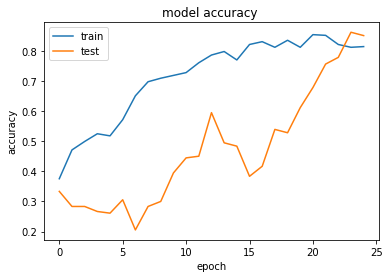

In [20]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

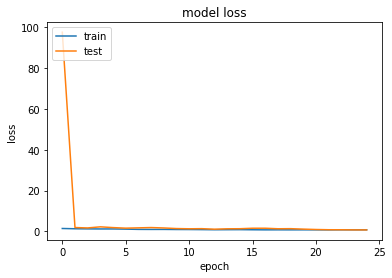

In [21]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 5s 441ms/step - loss: 0.7318 - accuracy: 0.8476


[0.7317583560943604, 0.8475610017776489]

In [23]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 5s 468ms/step - loss: 0.7367 - accuracy: 0.8580


[0.7366885542869568, 0.8579545617103577]

In [24]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 5s 440ms/step


In [0]:
class_label=list(train_generator.class_indices.keys())


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

0 Black spot
1 Melanose
2 canker
3 greening
4 healthy


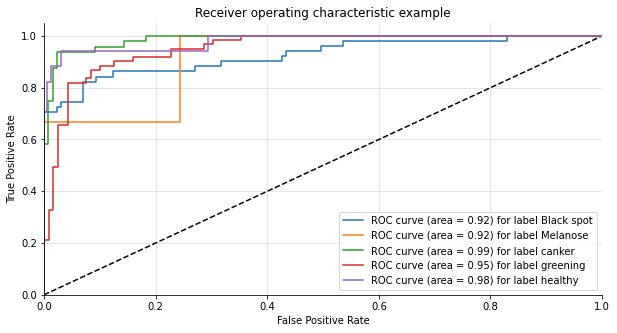

In [27]:
plot_multiclass_roc( y_pred, pd.get_dummies(y_true), n_classes=5,class_label=class_label, figsize=(10, 5))

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [29]:
y_pred.shape,y_true.shape

((180,), (180,))

In [30]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.8666666666666667
0.8565547413702947


In [31]:
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.81      0.84      0.83        51
    Melanose       1.00      0.67      0.80         3
      canker       0.88      0.94      0.91        48
    greening       0.89      0.84      0.86        61
     healthy       0.88      0.88      0.88        17

    accuracy                           0.87       180
   macro avg       0.89      0.83      0.86       180
weighted avg       0.87      0.87      0.87       180



### Imagenet weights

In [32]:
from tensorflow.keras.applications.densenet import DenseNet121
model =DenseNet121(weights = 'imagenet', include_top=False, input_shape = (img_shape,img_shape,3))


29089792/29084464 [==============================] - 1s 0us/step


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [37]:

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 7,177,285
Trainable params: 7,093,637
Non-trainable params: 83,648


In [39]:
%%time
results = model.fit(train_generator,epochs=25,verbose=0,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

CPU times: user 12min 38s, sys: 58.9 s, total: 13min 37s
Wall time: 10min 25s


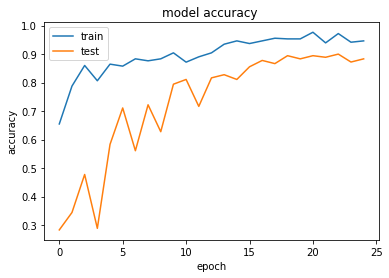

In [40]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

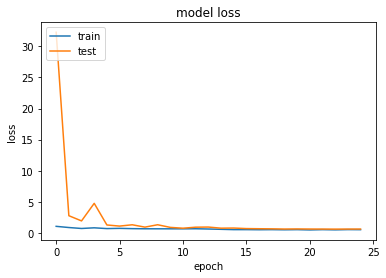

In [41]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 5s 446ms/step - loss: 0.6065 - accuracy: 0.9024


[0.6064687371253967, 0.9024389982223511]

In [43]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 5s 476ms/step - loss: 0.6255 - accuracy: 0.8920


[0.6254623532295227, 0.8920454382896423]

In [44]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 5s 441ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

0 Black spot
1 Melanose
2 canker
3 greening
4 healthy


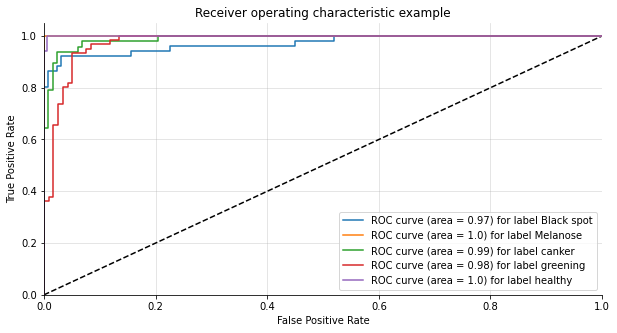

In [46]:
plot_multiclass_roc( y_pred, pd.get_dummies(y_true), n_classes=5,class_label=class_label, figsize=(10, 5))

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [48]:
y_pred.shape,y_true.shape

((180,), (180,))

In [49]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.9055555555555556
0.9319084533038021


In [50]:
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.92      0.88      0.90        51
    Melanose       1.00      1.00      1.00         3
      canker       0.95      0.83      0.89        48
    greening       0.85      0.95      0.90        61
     healthy       0.94      1.00      0.97        17

    accuracy                           0.91       180
   macro avg       0.93      0.93      0.93       180
weighted avg       0.91      0.91      0.91       180



## EfficientNetB3

In [0]:
import efficientnet.tfkeras as efn
model =efn.EfficientNetB3(weights =None, include_top=False, input_shape = (img_shape,img_shape,3))


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [56]:

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 10,988,845
Trainable params: 10,901,549
Non-trainable params: 87,296


In [57]:
%%time
results = model.fit(train_generator,epochs=25,verbose=0,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

CPU times: user 17min 16s, sys: 2min 47s, total: 20min 3s
Wall time: 13min 56s


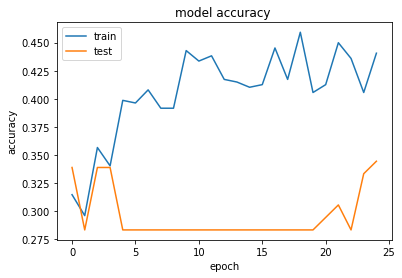

In [58]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

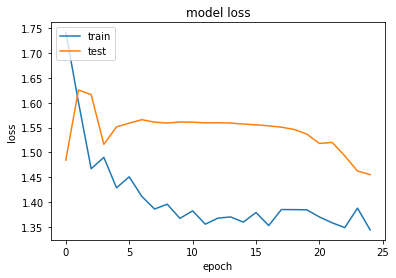

In [59]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 5s 464ms/step - loss: 1.4693 - accuracy: 0.2866


[1.4693111181259155, 0.28658536076545715]

In [61]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 5s 487ms/step - loss: 1.4039 - accuracy: 0.3011


[1.4039289951324463, 0.3011363744735718]

In [62]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 6s 458ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

0 Black spot
1 Melanose
2 canker
3 greening
4 healthy


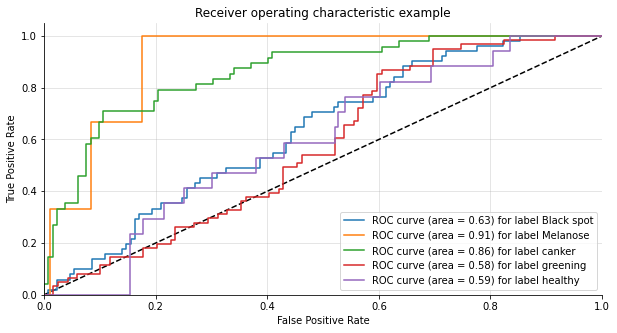

In [64]:
plot_multiclass_roc( y_pred, pd.get_dummies(y_true), n_classes=5,class_label=class_label, figsize=(10, 5))

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [66]:
y_pred.shape,y_true.shape

((180,), (180,))

In [67]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.3111111111111111
0.1756965944272446


In [68]:
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.34      0.78      0.47        51
    Melanose       0.00      0.00      0.00         3
      canker       0.88      0.15      0.25        48
    greening       0.17      0.15      0.16        61
     healthy       0.00      0.00      0.00        17

    accuracy                           0.31       180
   macro avg       0.28      0.22      0.18       180
weighted avg       0.39      0.31      0.25       180



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### image net weights

In [69]:
import efficientnet.tfkeras as efn
model =efn.EfficientNetB3(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))


44113920/44107200 [==============================] - 2s 0us/step


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [74]:

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 10,988,845
Trainable params: 10,901,549
Non-trainable params: 87,296


In [75]:
%%time
results = model.fit(train_generator,epochs=25,verbose=0,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

Epoch 1/25
27/26 [==============================] - 35s 1s/step - loss: 1.0292 - accuracy: 0.6830 - val_loss: 1.8986 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 2/25
27/26 [==============================] - 32s 1s/step - loss: 0.6945 - accuracy: 0.8625 - val_loss: 2.1387 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/25
27/26 [==============================] - 33s 1s/step - loss: 0.6530 - accuracy: 0.9091 - val_loss: 1.3466 - val_accuracy: 0.5722 - lr: 0.0010
Epoch 4/25
27/26 [==============================] - 32s 1s/step - loss: 0.6737 - accuracy: 0.9091 - val_loss: 1.6888 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 5/25
27/26 [==============================] - 33s 1s/step - loss: 0.6281 - accuracy: 0.9161 - val_loss: 1.1180 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 6/25
27/26 [==============================] - 32s 1s/step - loss: 0.7044 - accuracy: 0.8671 - val_loss: 1.3327 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 7/25
27/26 [==============================] - 32s 1s/step - loss: 0.6031 - a

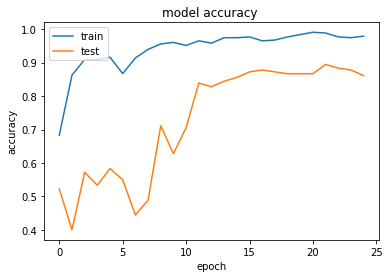

In [76]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

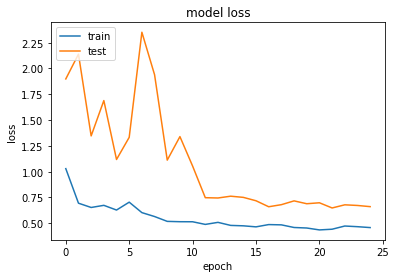

In [77]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 5s 456ms/step - loss: 0.6919 - accuracy: 0.8720


[0.6919382810592651, 0.8719512224197388]

In [79]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 5s 484ms/step - loss: 0.6965 - accuracy: 0.8807


[0.6965118050575256, 0.8806818127632141]

In [80]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 5s 452ms/step


In [0]:
class_label=list(train_generator.class_indices.keys())


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

0 Black spot
1 Melanose
2 canker
3 greening
4 healthy


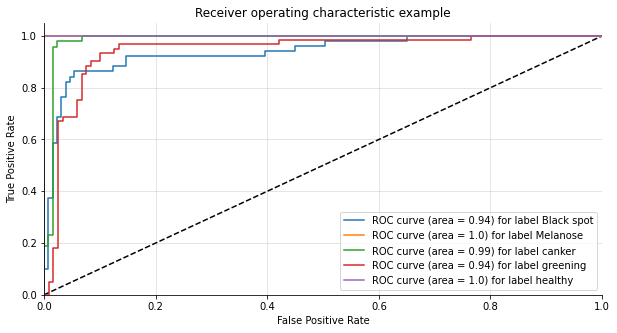

In [83]:
plot_multiclass_roc( y_pred, pd.get_dummies(y_true), n_classes=5,class_label=class_label, figsize=(10, 5))

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [85]:
y_pred.shape,y_true.shape

((180,), (180,))

In [86]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.8777777777777778
0.919787250752359


In [87]:
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.79      0.86      0.82        51
    Melanose       1.00      1.00      1.00         3
      canker       0.96      0.92      0.94        48
    greening       0.86      0.82      0.84        61
     healthy       1.00      1.00      1.00        17

    accuracy                           0.88       180
   macro avg       0.92      0.92      0.92       180
weighted avg       0.88      0.88      0.88       180

